## 1) Get the data: SDSS spectra and class labels
<img src="https://www.sdss.org/wp-content/uploads/2014/11/SDSS_telescope_new.jpg" width=500 />
The Sloan Digital Sky Survey (SDSS) is a full-sky survey that has been running at Apache Point Observatory since 2000. Up-to-date information can be found here: https://www.sdss.org/.
In this tutorial we will use spectra taken with spectroscopic plates as shown below. See http://voyages.sdss.org/preflight/sdss-plates/ for more information on these. 
<img src="https://www.sdss.org/wp-content/uploads/2019/11/apogeen-plugging.png" width=300 />

In [1]:
import matplotlib.pyplot as plt
from astropy.io import fits
import numpy as np
import os
import csv
import tensorflow as tf

data_path = 'data_spectra/'

# list of flux values, labels, and wavelength values
data = np.load(data_path + "data.npy")
labels = np.load(data_path + "labels.npy")
wavelengths = np.load(data_path + "wavelengths.npy")
print(np.shape(data))

# list number of objects
numbers = range(np.shape(data)[0])
# datapoints per spectrum
wave_shape = np.shape(data)[1]

(7000, 3522)


## 2) Plot our spectra

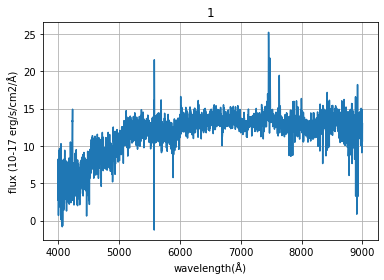

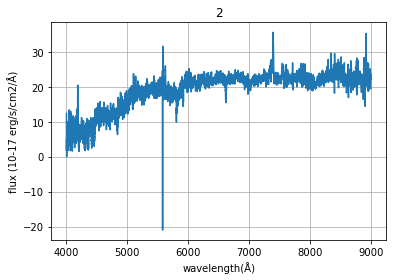

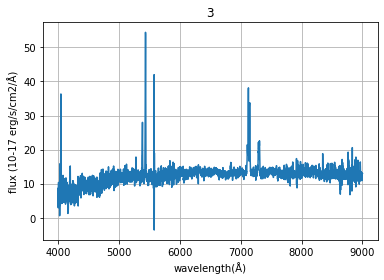

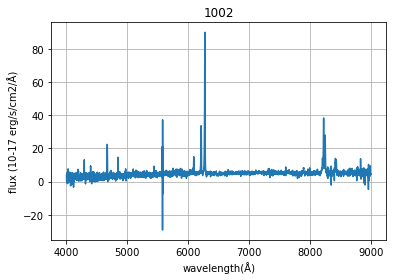

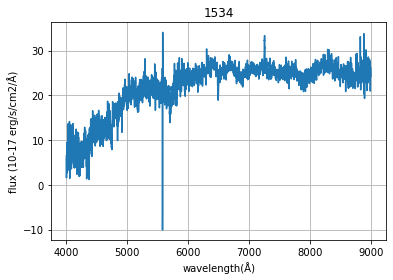

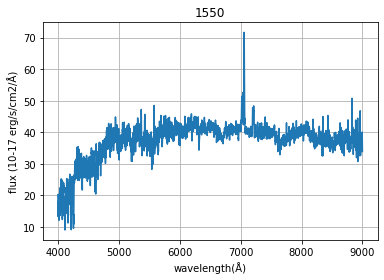

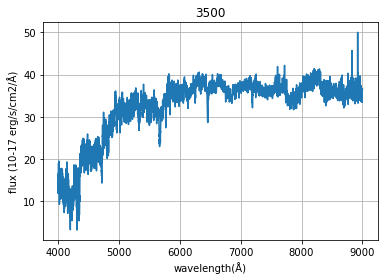

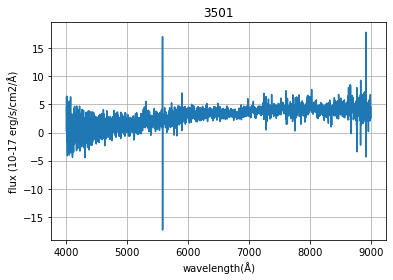

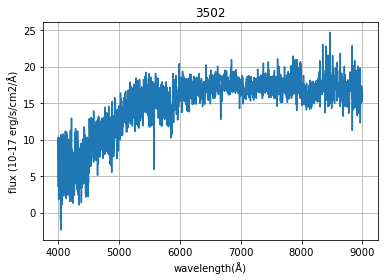

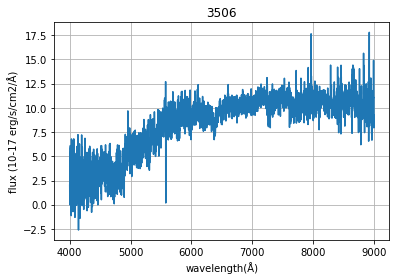

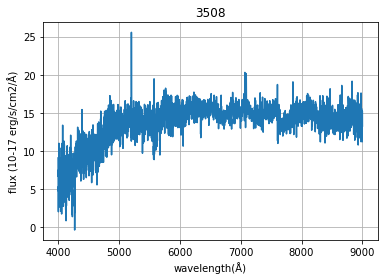

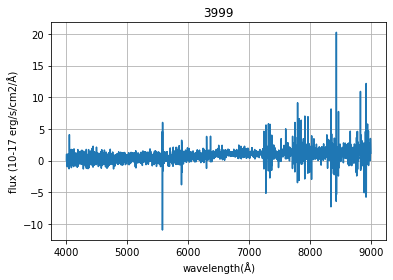

In [2]:
for i in [1, 2, 3, 1002, 1534, 1550, 3500,3501,3502,3506,3508,3999]: # some example spectra
    plt.plot(wavelengths, data[i]) 
    plt.xlabel('wavelength(Å)') 
    plt.ylabel('flux (10-17 erg/s/cm2/Å)') 
    # 10^7 erg = 1 Joule (energy)
    plt.grid(True)
    plt.title(str(i))
    plt.show()

## 3) Create training and test data set

In [3]:
import random

# shuffle the data
z = list(zip(data, labels, numbers)) 
random.shuffle(z)
data_shuffled, labels_shuffled, numbers_shuffled = zip(*z)

print(np.array(data_shuffled).shape)
print(np.array(labels_shuffled).shape)

(7000, 3522)
(7000,)


In [4]:
# test and training split
percent_split = 0.9
split_index = int(len(data_shuffled)*percent_split)

# Flux
data_training = np.asarray(data_shuffled[:split_index])
data_test = np.asarray(data_shuffled[split_index:])

# Labels
labels_training = np.asarray(labels_shuffled[:split_index])
labels_test = np.asarray(labels_shuffled[split_index:])

# Number
numbers_training = numbers_shuffled[:split_index]
numbers_test = numbers_shuffled[split_index:]

In [5]:
# reshape training and test set
input_shape = (wave_shape,1)

data_training_r = np.reshape(data_training, newshape=(len(data_training), input_shape[0], input_shape[1]))
data_test_r  = np.reshape(data_test, newshape=(len(data_test), input_shape[0], input_shape[1]))

print(data_training_r.shape)
print(data_test_r.shape)

(6300, 3522, 1)
(700, 3522, 1)


In [6]:
# further set-up of training and test data, optional normalization
do_normalize = True

if do_normalize:
    # L2-normalization (i.e. the sum of squared of elements is set equal to one)
    x_train = tf.keras.utils.normalize(data_training_r, axis=1)
    x_test = tf.keras.utils.normalize(data_test_r, axis=1)
else:
    x_train = data_training_r
    x_test = data_test_r

y_train = labels_training
y_test = labels_test

## 4) Create the network

In [7]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, Conv1D, MaxPooling1D, Dropout, InputLayer, GlobalAveragePooling1D
from tensorflow.keras.metrics import Accuracy
from tensorflow import keras
from tensorflow.keras import layers

In [8]:
# create network model
# example - try out what happens if you alter different hyperparameters

no_filter = 32
kernel_size = 20
strides = 10
dropout = 0.35
pooling = 3

# our model or architecture
model = tf.keras.Sequential([
    # add convolutional layer
    Conv1D(filters=no_filter, kernel_size=kernel_size, strides=strides, activation='relu', input_shape=input_shape), # stride
    # max-pooling against overfitting
    MaxPooling1D(pooling), 
    # dropout against overfitting
    Dropout(dropout), 
    # add convolutional layer
    Conv1D(filters=2*no_filter, kernel_size=2*kernel_size, strides=strides, activation='relu'),
    # max-pooling against overfitting
    MaxPooling1D(pooling),
    # dropout against overfitting
    Dropout(dropout),
    # flatten to feed into dense layers
    Flatten(),
    # Adds a densely-connected layer
    Dense(units=128, activation='relu'), # units = dimensionality of output
    # dropout again
    Dropout(dropout),
    # Add another dense layer, now a softmax (probability of different classes as the output)
    Dense(units=4, activation='softmax')
])

In [9]:
# compile the network model, choose optimiser, loss-function etc.
model.compile(optimizer='Adam', 
              loss='sparse_categorical_crossentropy', # labels provided as integers (not one-hot)
              metrics=['accuracy'])

In [10]:
# train the network model
history = model.fit(x_train, y_train,
                    epochs=200, validation_split=0.1,
                    shuffle=True, batch_size=200,
                    verbose=1)

# we can also save and/or load a model
#model = tf.keras.models.load_model('spectral_classifier_v2.h5')
#model.save('spectral_classifier_v2.h5')

Epoch 1/200
29/29 [==============================] - 3s 53ms/step - loss: 1.1939 - accuracy: 0.3656 - val_loss: 1.0592 - val_accuracy: 0.3413
Epoch 2/200
29/29 [==============================] - 1s 49ms/step - loss: 1.0423 - accuracy: 0.4377 - val_loss: 0.8915 - val_accuracy: 0.5968
Epoch 3/200
29/29 [==============================] - 1s 47ms/step - loss: 0.8116 - accuracy: 0.5778 - val_loss: 0.6983 - val_accuracy: 0.6190
Epoch 4/200
29/29 [==============================] - 1s 37ms/step - loss: 0.7084 - accuracy: 0.6162 - val_loss: 0.6813 - val_accuracy: 0.6492
Epoch 5/200
29/29 [==============================] - 1s 35ms/step - loss: 0.6727 - accuracy: 0.6446 - val_loss: 0.6682 - val_accuracy: 0.6571
Epoch 6/200
29/29 [==============================] - 1s 36ms/step - loss: 0.6537 - accuracy: 0.6677 - val_loss: 0.6611 - val_accuracy: 0.6524
Epoch 7/200
29/29 [==============================] - 1s 36ms/step - loss: 0.6345 - accuracy: 0.6721 - val_loss: 0.6577 - val_accuracy: 0.6603
Epoch 

29/29 [==============================] - 1s 37ms/step - loss: 0.3953 - accuracy: 0.8250 - val_loss: 0.3861 - val_accuracy: 0.8286
Epoch 59/200
29/29 [==============================] - 1s 35ms/step - loss: 0.3821 - accuracy: 0.8381 - val_loss: 0.3744 - val_accuracy: 0.8429
Epoch 60/200
29/29 [==============================] - 1s 36ms/step - loss: 0.3923 - accuracy: 0.8252 - val_loss: 0.3669 - val_accuracy: 0.8444
Epoch 61/200
29/29 [==============================] - 1s 37ms/step - loss: 0.3808 - accuracy: 0.8277 - val_loss: 0.3655 - val_accuracy: 0.8413
Epoch 62/200
29/29 [==============================] - 1s 37ms/step - loss: 0.3870 - accuracy: 0.8273 - val_loss: 0.3785 - val_accuracy: 0.8381
Epoch 63/200
29/29 [==============================] - 1s 36ms/step - loss: 0.3796 - accuracy: 0.8330 - val_loss: 0.3699 - val_accuracy: 0.8444
Epoch 64/200
29/29 [==============================] - 1s 36ms/step - loss: 0.3760 - accuracy: 0.8328 - val_loss: 0.3643 - val_accuracy: 0.8444
Epoch 65/200

29/29 [==============================] - 1s 36ms/step - loss: 0.2965 - accuracy: 0.8764 - val_loss: 0.3030 - val_accuracy: 0.8778
Epoch 116/200
29/29 [==============================] - 1s 38ms/step - loss: 0.2890 - accuracy: 0.8790 - val_loss: 0.3084 - val_accuracy: 0.8778
Epoch 117/200
29/29 [==============================] - 1s 36ms/step - loss: 0.2769 - accuracy: 0.8854 - val_loss: 0.3000 - val_accuracy: 0.8825
Epoch 118/200
29/29 [==============================] - 1s 35ms/step - loss: 0.2904 - accuracy: 0.8778 - val_loss: 0.3153 - val_accuracy: 0.8762
Epoch 119/200
29/29 [==============================] - 1s 37ms/step - loss: 0.2878 - accuracy: 0.8735 - val_loss: 0.2984 - val_accuracy: 0.8746
Epoch 120/200
29/29 [==============================] - 1s 35ms/step - loss: 0.2878 - accuracy: 0.8785 - val_loss: 0.2974 - val_accuracy: 0.8857
Epoch 121/200
29/29 [==============================] - 1s 36ms/step - loss: 0.2808 - accuracy: 0.8822 - val_loss: 0.3052 - val_accuracy: 0.8714
Epoch 

Epoch 172/200
29/29 [==============================] - 1s 39ms/step - loss: 0.2323 - accuracy: 0.8982 - val_loss: 0.2921 - val_accuracy: 0.8905
Epoch 173/200
29/29 [==============================] - 1s 39ms/step - loss: 0.2414 - accuracy: 0.8968 - val_loss: 0.3106 - val_accuracy: 0.8714
Epoch 174/200
29/29 [==============================] - 1s 40ms/step - loss: 0.2407 - accuracy: 0.8947 - val_loss: 0.3080 - val_accuracy: 0.8746
Epoch 175/200
29/29 [==============================] - 1s 40ms/step - loss: 0.2260 - accuracy: 0.9056 - val_loss: 0.2946 - val_accuracy: 0.8984
Epoch 176/200
29/29 [==============================] - 1s 40ms/step - loss: 0.2289 - accuracy: 0.9060 - val_loss: 0.2992 - val_accuracy: 0.8952
Epoch 177/200
29/29 [==============================] - 1s 39ms/step - loss: 0.2273 - accuracy: 0.9060 - val_loss: 0.3302 - val_accuracy: 0.8825
Epoch 178/200
29/29 [==============================] - 1s 43ms/step - loss: 0.2316 - accuracy: 0.9032 - val_loss: 0.2988 - val_accuracy:

## 5) Monitor the training

In [11]:
def plot_accuracy(name, ylim=[0,1.01]):
    #plt.plot(history.history['acc'])
    plt.plot(history.history['accuracy'])
    #plt.plot(history.history['val_acc'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.ylim(ylim[0], ylim[1])
    plt.legend(['training', 'validation'], loc='upper left')
    plt.savefig(name)
    plt.show()

In [12]:
def plot_loss(name, ylim=[0,2]):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.ylim(ylim[0],ylim[1])
    plt.legend(['training', 'validation'], loc='upper left')
    plt.savefig(name)
    plt.show()


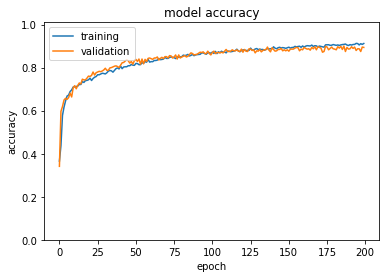

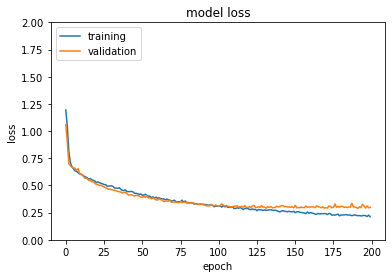

In [13]:
plot_accuracy("accuracy_graph_goldbig.png")
plot_loss("loss_graph_goldbig.png")

## Test the network model - predictive performance

In [14]:
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt

In [15]:
# predict on the test data
predictions = model.predict(x=x_test)
rounded_predictions = np.argmax(predictions, axis=-1)

class_names = ['AGN','galaxy','QSO','star']

22/22 [==============================] - 0s 3ms/step


### Confusion Matrix

In [16]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[213  21   2]
 [ 30 232   5]
 [ 12   6 179]]


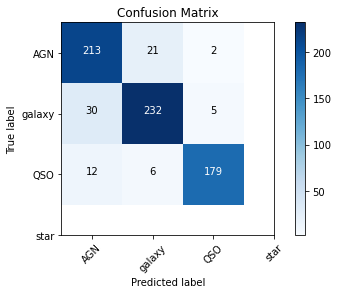

In [17]:
cm = confusion_matrix(y_true=y_test, y_pred=rounded_predictions)
plot_confusion_matrix(cm=cm, classes=class_names, title='Confusion Matrix')

## Confusion matrix (percentage)

Confusion matrix, without normalization
[[90.25  8.9   0.85]
 [11.24 86.89  1.87]
 [ 6.09  3.05 90.86]]


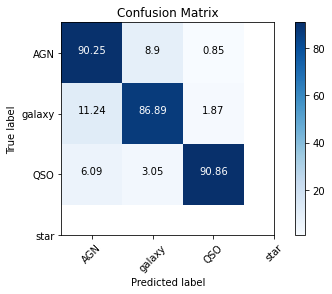

In [18]:
cm = confusion_matrix(y_true=y_test, y_pred=rounded_predictions)
cm_shape = np.shape(cm)

cm_percentages = np.zeros(shape=cm_shape)
for i in range(cm_shape[0]):
    total_objects = sum(cm[i])
    
    for t in range(cm_shape[0]):
        number_guessed = cm[i][t]
        cm_percentages[i][t] = round(number_guessed/total_objects*100,2)

plot_confusion_matrix(cm=cm_percentages, classes=class_names, title='Confusion Matrix')

## Class-wise accuracy

In [19]:
class_accuaracy = []

for i in range(cm_shape[0]):
    total_objects = sum(cm[i])
    correct_guesses = cm[i][i]
    class_accuaracy.append(correct_guesses/total_objects)
    
print("Accuracy for class")
for i in range(cm_shape[0]):
    print(class_names[i], "\t:", round(class_accuaracy[i],4)*100, "%")

Accuracy for class
AGN 	: 90.25 %
galaxy 	: 86.89 %
QSO 	: 90.86 %


## Having a look at false predictions

**Label 0 = AGN** \
**Label 1 = galaxy** \
**Label 2 = QSO** \
**Label 3 = star**

In [20]:
predictions = model.predict(x=x_test)
rounded_predictions = np.argmax(predictions, axis=-1)

wrong_predictions = []

for i in range(len(rounded_predictions)):
    if rounded_predictions[i] != y_test[i]:
        wrong_predictions.append(numbers_test[i])      

wrong_predictions.sort()
        
print(len(rounded_predictions), "right")
print(len(wrong_predictions), "false")
print(str(((len(rounded_predictions)-len(wrong_predictions))/len(rounded_predictions))*100) + "% correctly classified")

22/22 [==============================] - 0s 3ms/step
700 right
76 false
89.14285714285714% correctly classified


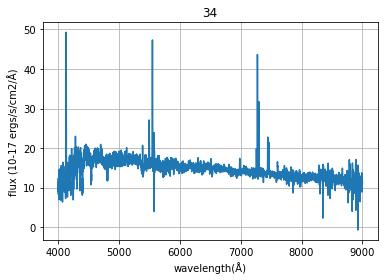

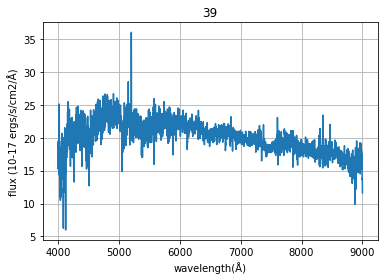

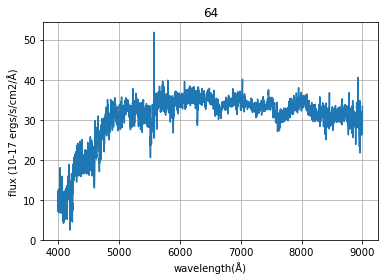

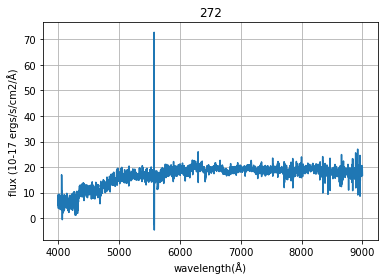

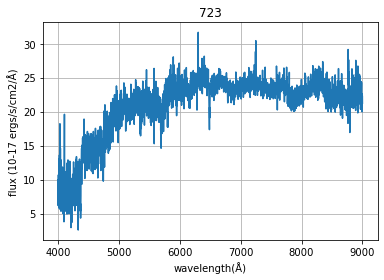

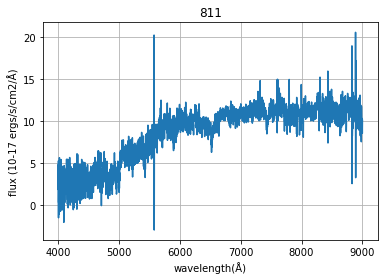

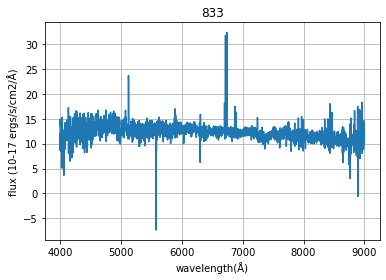

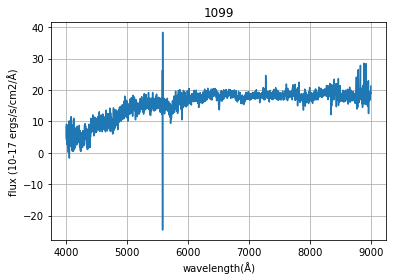

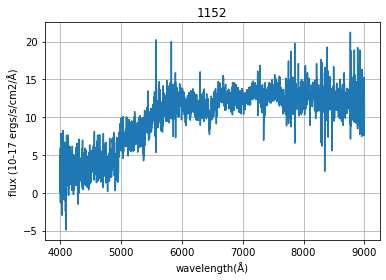

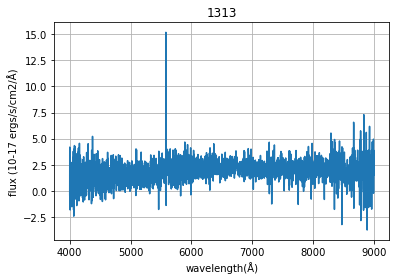

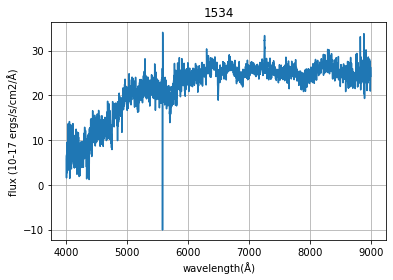

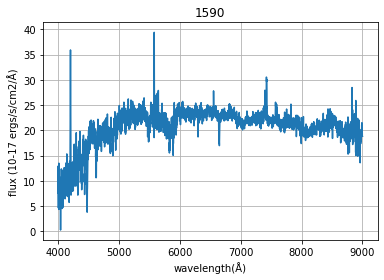

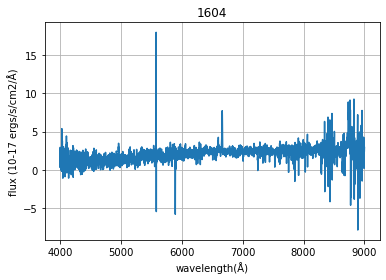

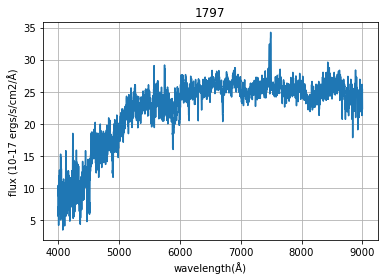

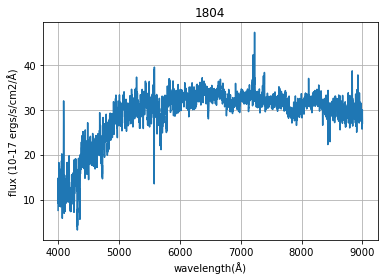

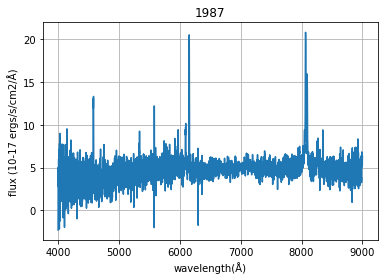

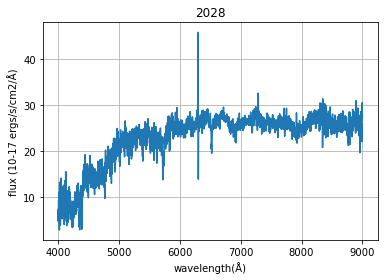

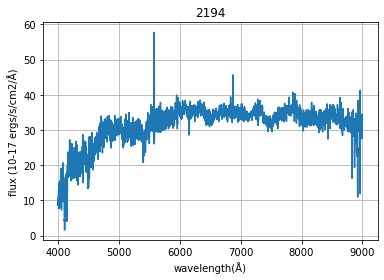

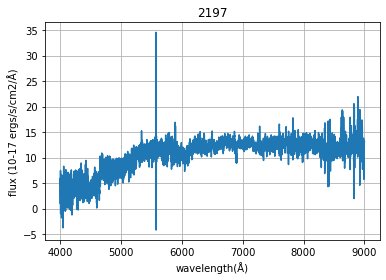

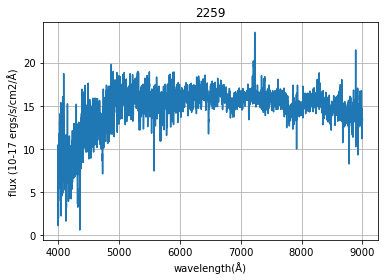

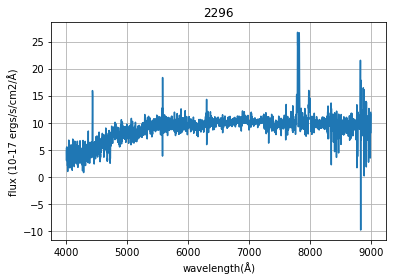

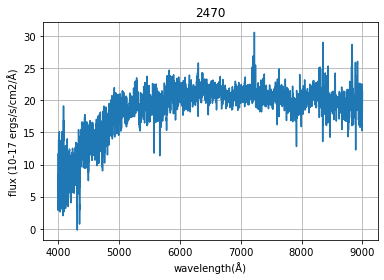

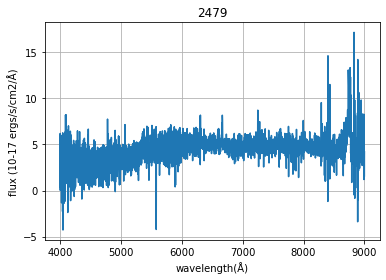

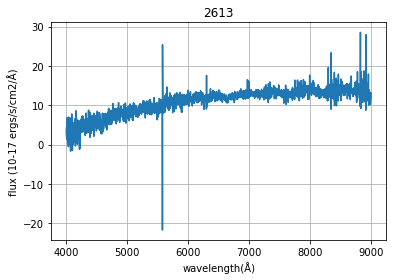

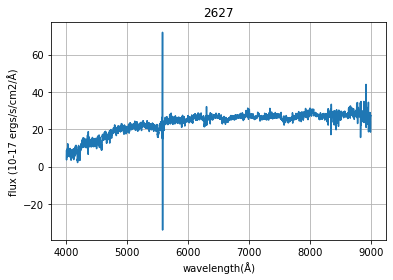

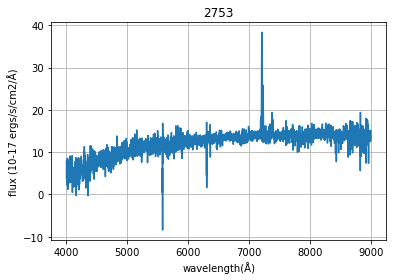

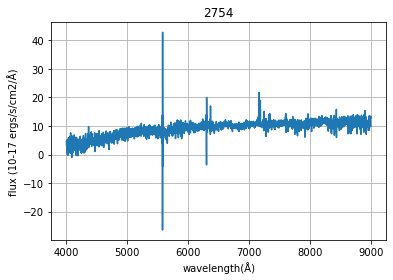

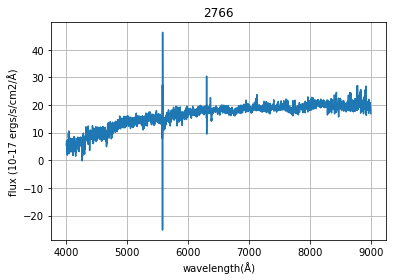

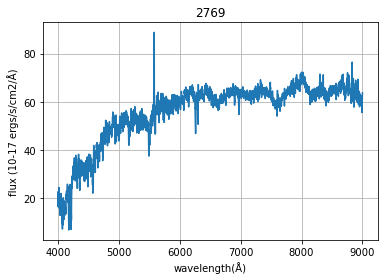

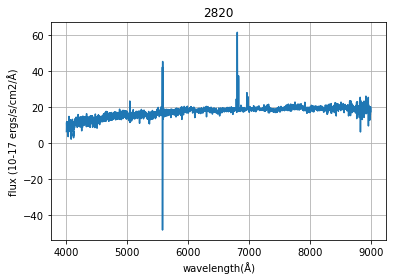

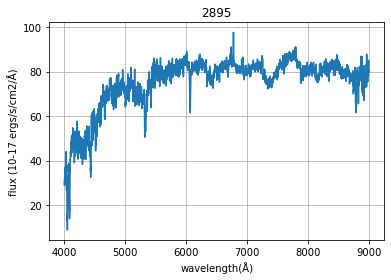

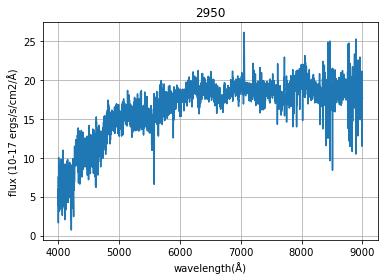

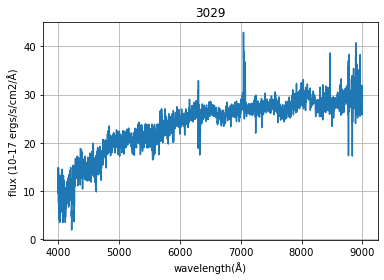

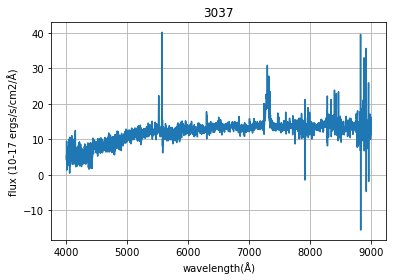

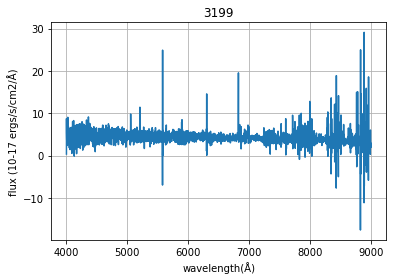

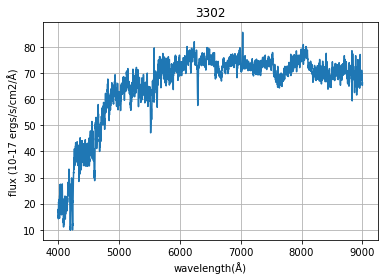

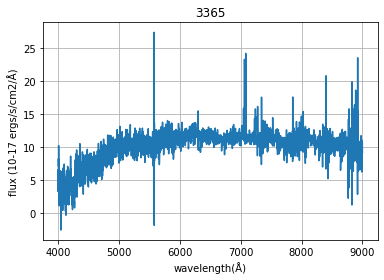

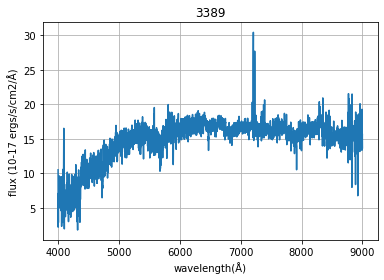

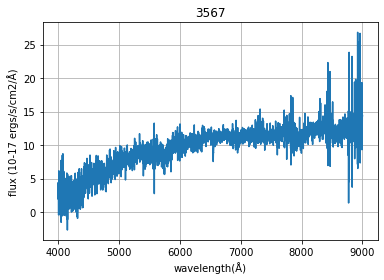

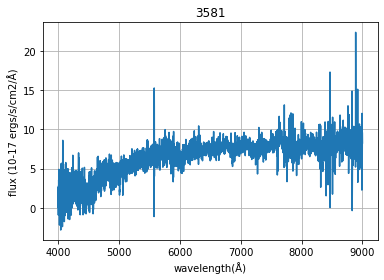

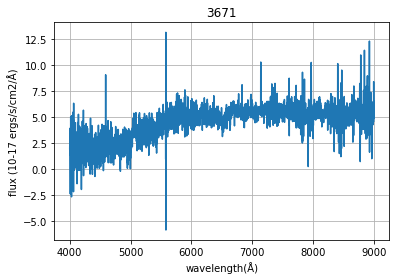

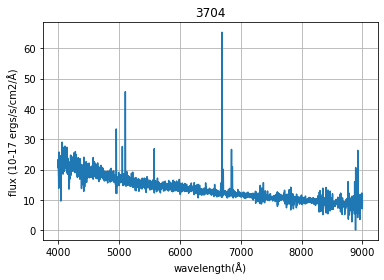

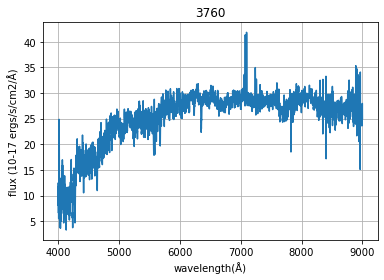

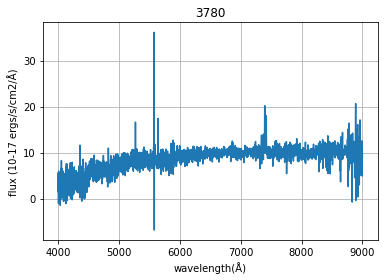

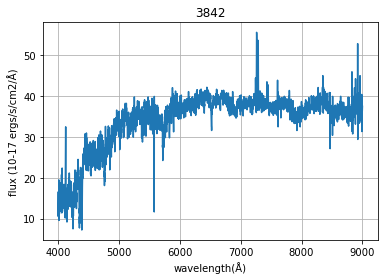

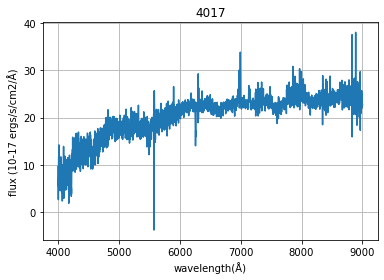

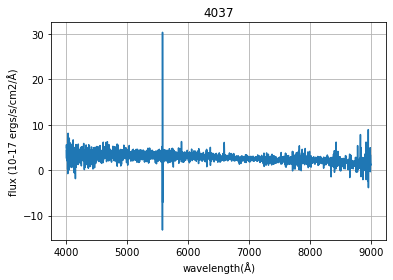

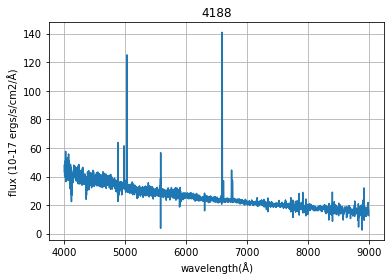

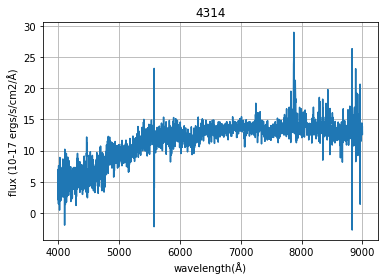

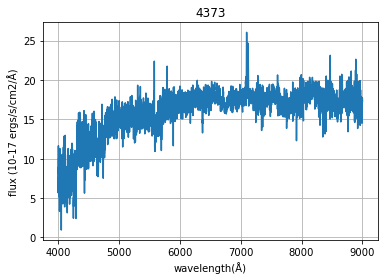

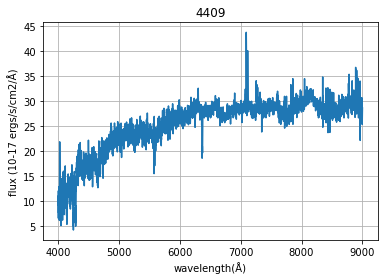

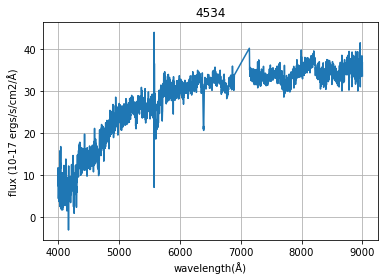

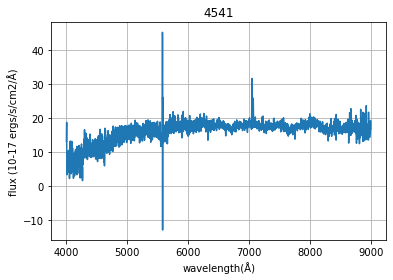

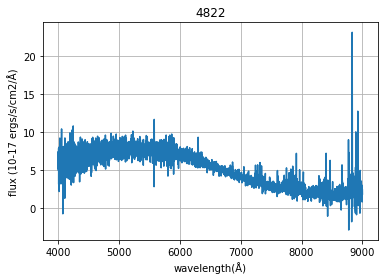

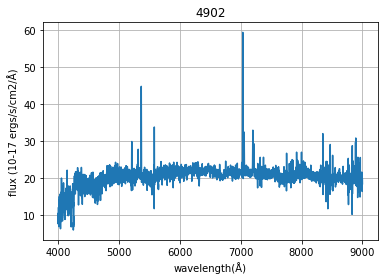

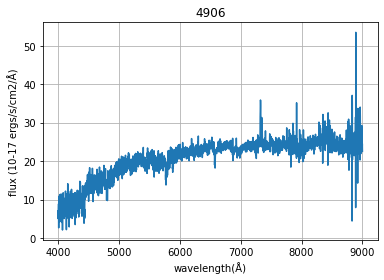

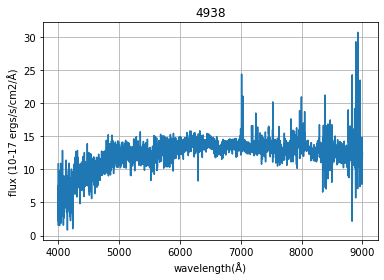

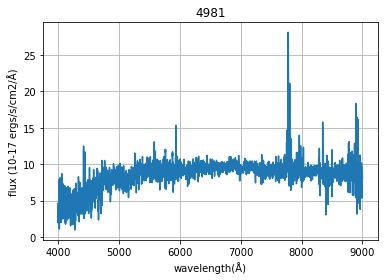

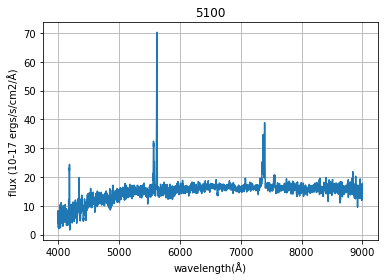

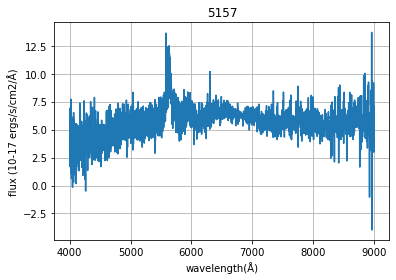

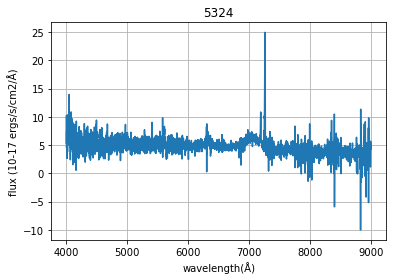

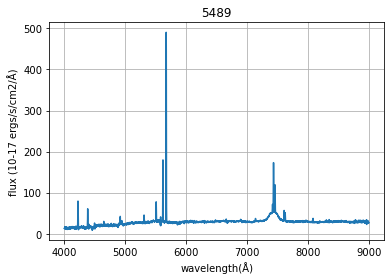

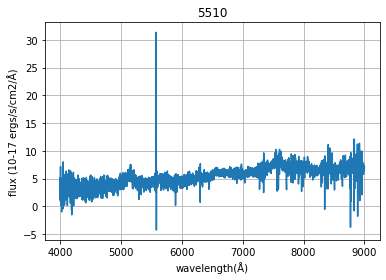

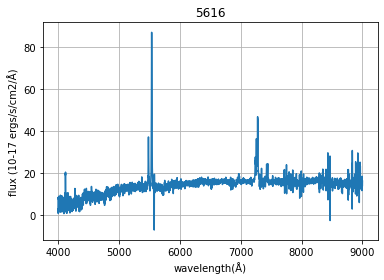

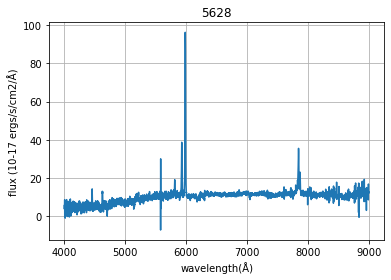

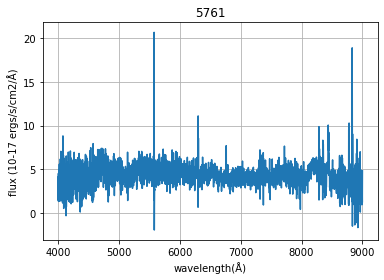

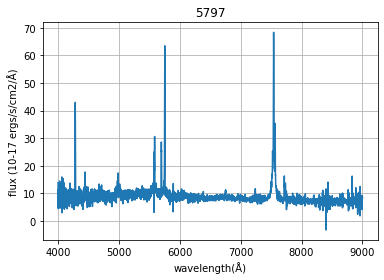

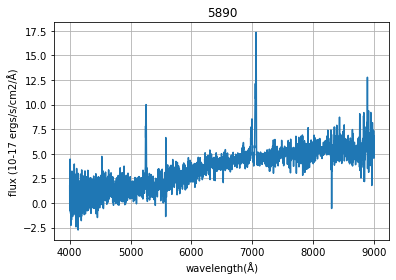

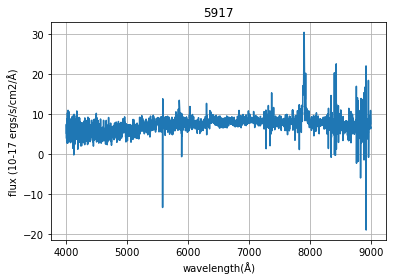

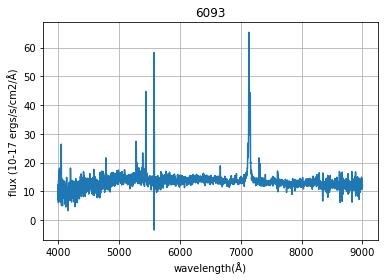

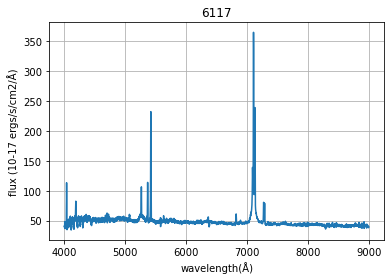

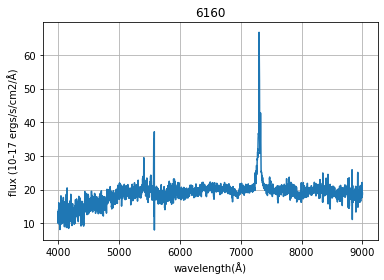

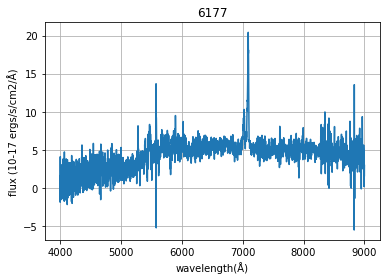

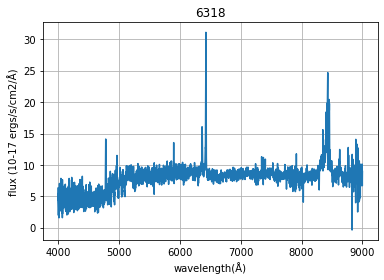

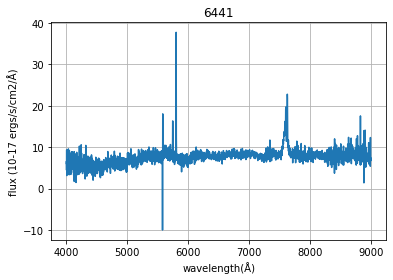

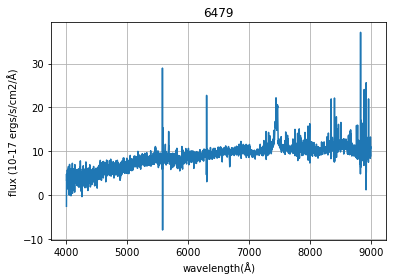

In [21]:
for i in wrong_predictions:  
    plt.plot(wavelengths, data[i]) 
    plt.xlabel('wavelength(Å)') 
    plt.ylabel('flux (10-17 ergs/s/cm2/Å)') 
    plt.grid(True)
    plt.title(str(i))
    plt.show()

## Simple benchmarking with the scikit-learn package

In [22]:
# SVM support vector machine
# see: https://scikit-learn.org/stable/modules/svm.html
from sklearn import svm
clf = svm.SVC(gamma=0.001, C=100.)
clf.fit(data_training, labels_training)
clf.score(data_test, labels_test)

0.36714285714285716

In [23]:
# Random forest
# see: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
from sklearn.ensemble import RandomForestClassifier
clf2 = RandomForestClassifier(n_estimators=100, random_state=123)
clf2.fit(data_training, labels_training)
clf2.score(data_test, labels_test)

0.7557142857142857

In [24]:
# Logistic regression
# see: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
from sklearn.linear_model import LogisticRegression
clf1 = LogisticRegression(max_iter=10000, random_state=123)
clf1.fit(data_training, labels_training)
clf1.score(data_test, labels_test)

0.8328571428571429

In [25]:
# Gaussian naive Bayes
# see: https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html
from sklearn.naive_bayes import GaussianNB
clf3 = GaussianNB()
clf3.fit(data_training, labels_training)
clf3.score(data_test, labels_test)

0.4642857142857143